In [43]:
# ! pip install pandas numpy matplotlib scikit-learn mlxtend tensorflow keras
# ! pip install --upgrade keras
# ! pip install np_utils
# ! pip install ipywidgets


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/4a/0e/57ed498fafbc60419a9332d872e929879ceba2d73cb11d284d7112472b3e/ipywidgets-8.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.9 from https://files.pythonhosted.org/packages/29/03/107d96077c4befed191f7ad1a12c7b52a8f9d2778a5836d59f9855c105f6/widgetsnbextension-4.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.9 from https://files.pythonhosted.org/packages/e8/05/0ebab152288693b5ec7b339aab857362947031143b282853b4c2dd4b5b40/jupyterlab_widgets-3.0.9-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   -- ------------------------------------- 10.2/139.4 kB ? eta -:--:--
   ---------------------------------------- 139.4/139.4 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/214.9 kB ? eta -:--:--
   --------------------------------------- 2

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from keras import models
from keras.utils import to_categorical

from tensorflow import convert_to_tensor
from tensorflow.image import grayscale_to_rgb
from tensorflow.data import Dataset
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

In [3]:
data = pd.read_csv('https://github.com/unclethien/Facial-Expression-Recognition/raw/main/Dataset/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
data[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [5]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [6]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [7]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [8]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [9]:
# As the pretrained model expects rgb images, we convert our grayscale images with a single channel to pseudo-rgb images with 3 channels
train_images_rgb = grayscale_to_rgb(convert_to_tensor(train_images))
val_images_rgb = grayscale_to_rgb(convert_to_tensor(val_images))
test_images_rgb =  grayscale_to_rgb(convert_to_tensor(test_images))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_rgb_datagen = ImageDataGenerator(
    rotation_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)

train_rgb_datagen.fit(train_images_rgb)

In [11]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

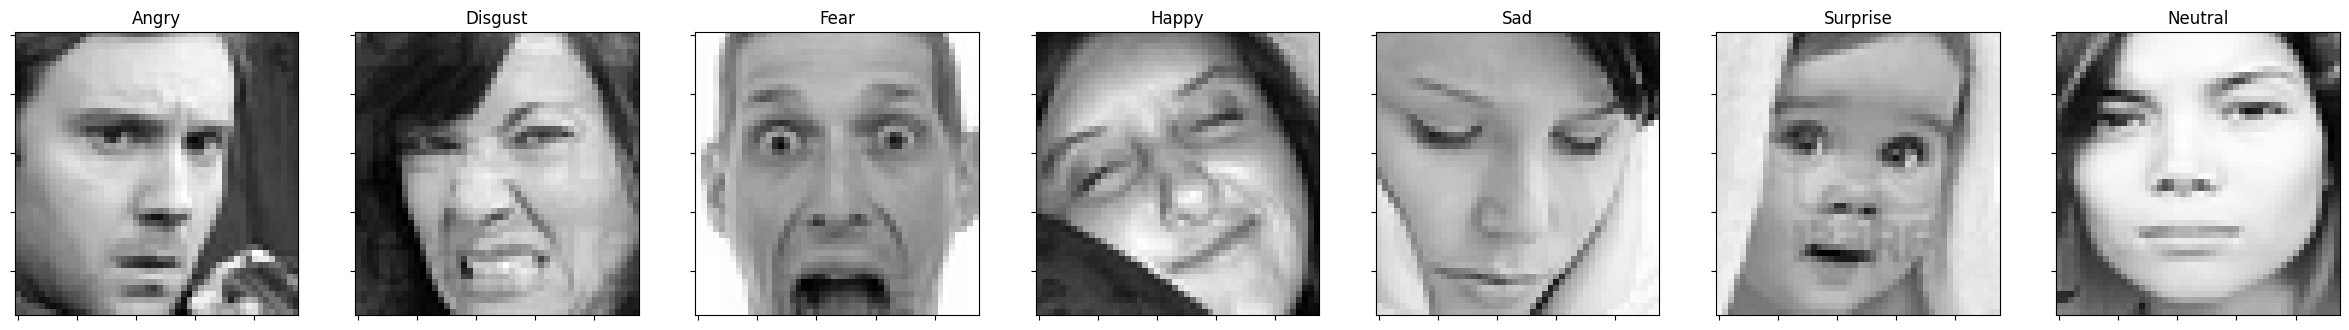

In [12]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

plot_all_emotions()

In [13]:
#Plot 5 examples of one emotion
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

#### Angry

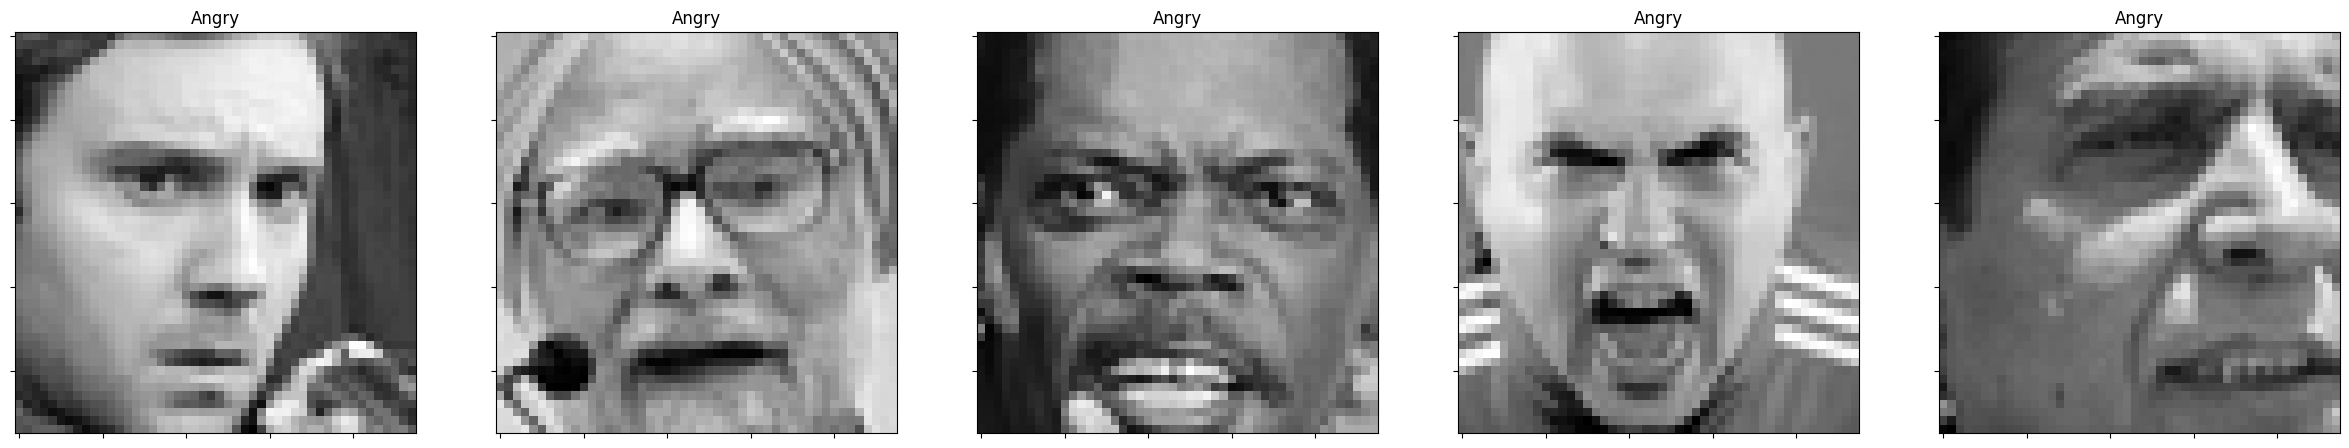

In [14]:
plot_examples(label=0)

#### Digust

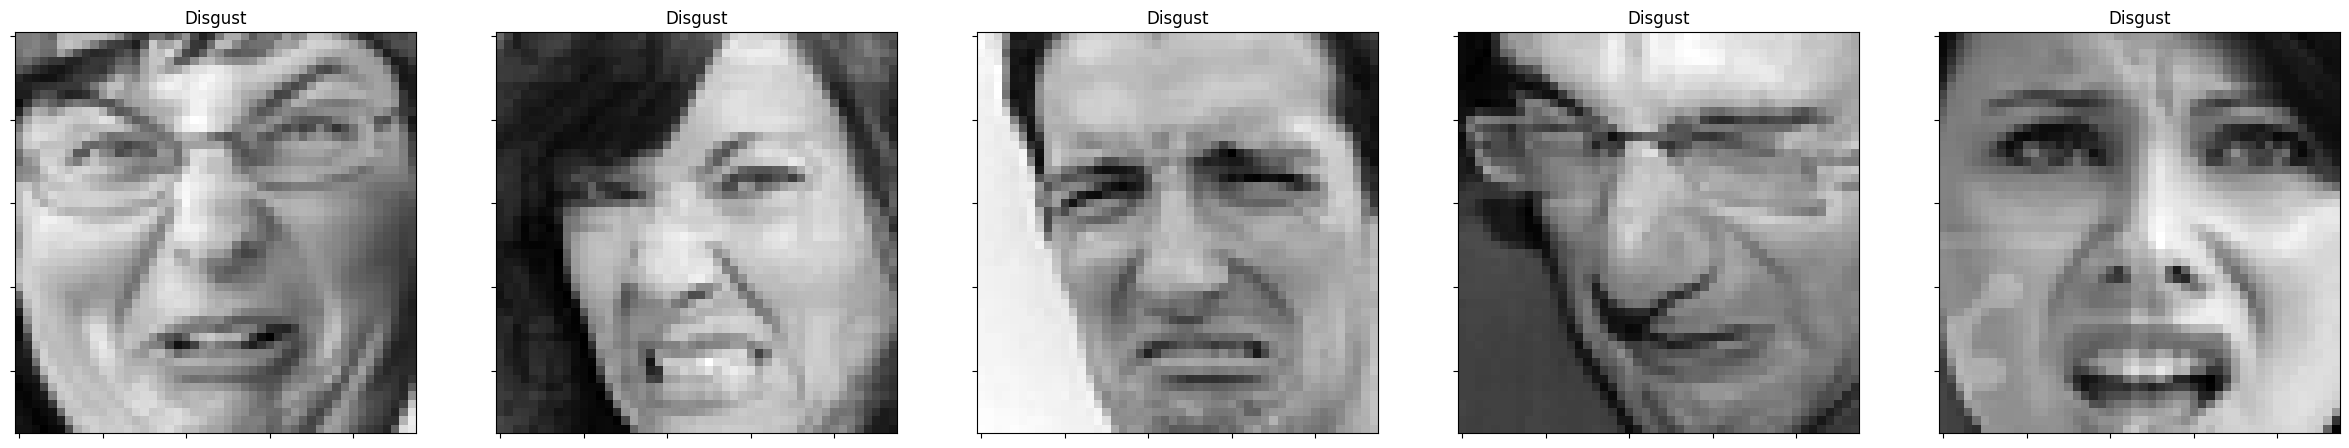

In [15]:
plot_examples(label=1)

#### Fear

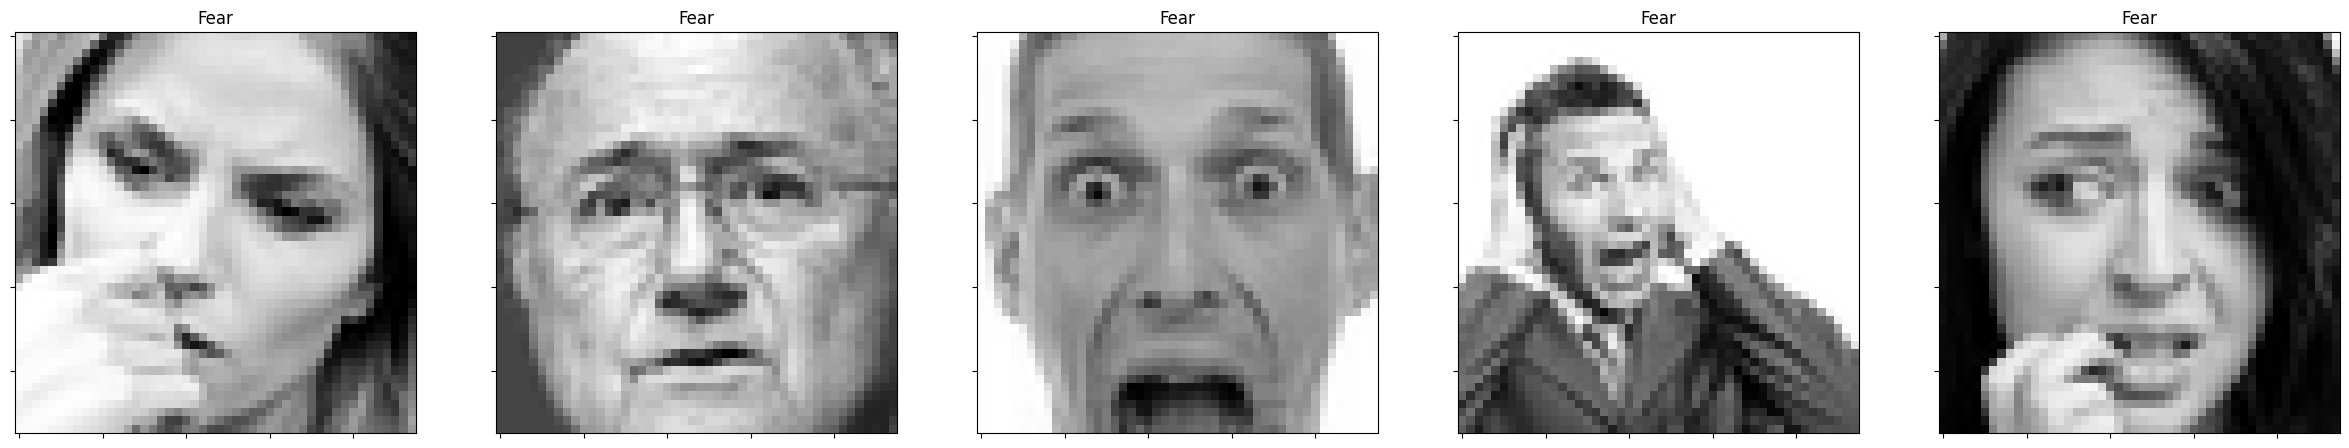

In [16]:
plot_examples(label=2)

#### Happy

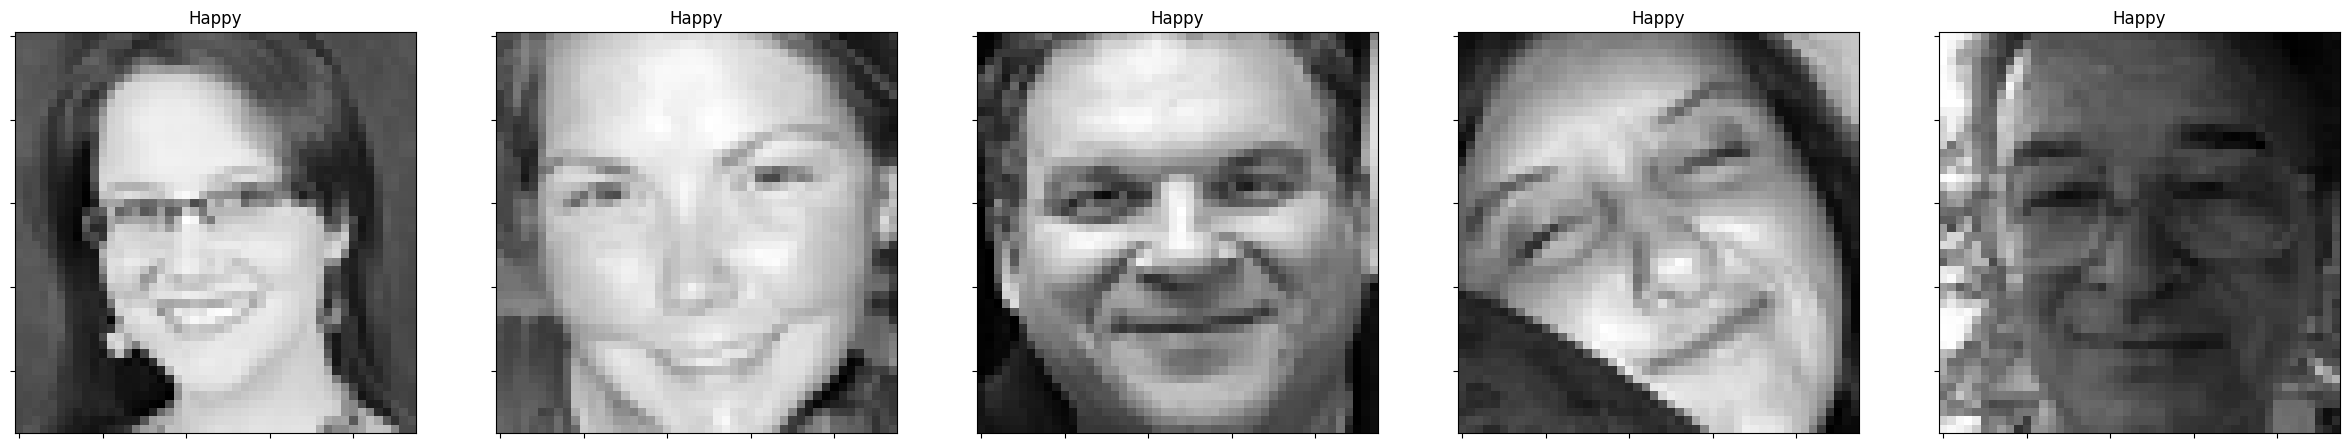

In [17]:
plot_examples(label=3)

#### Surprise

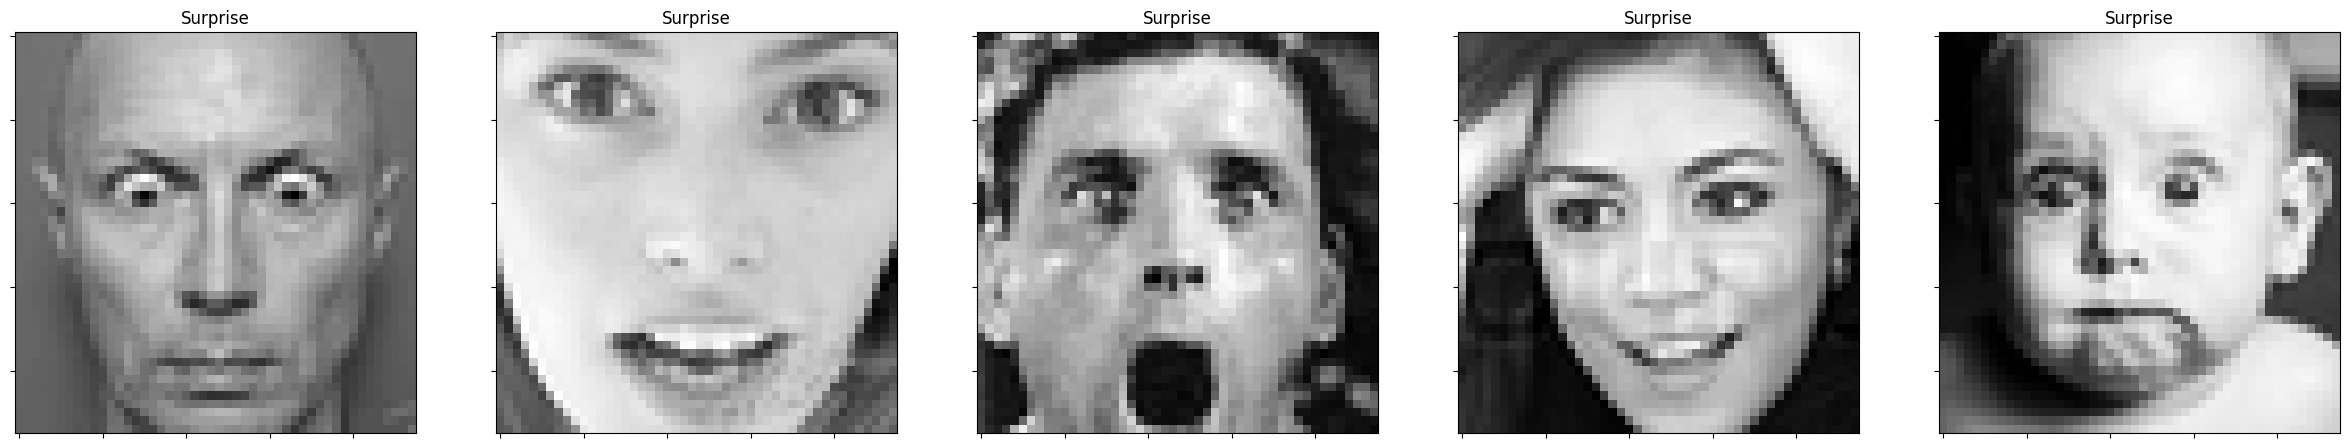

In [18]:
plot_examples(label=5)

#### Neutral

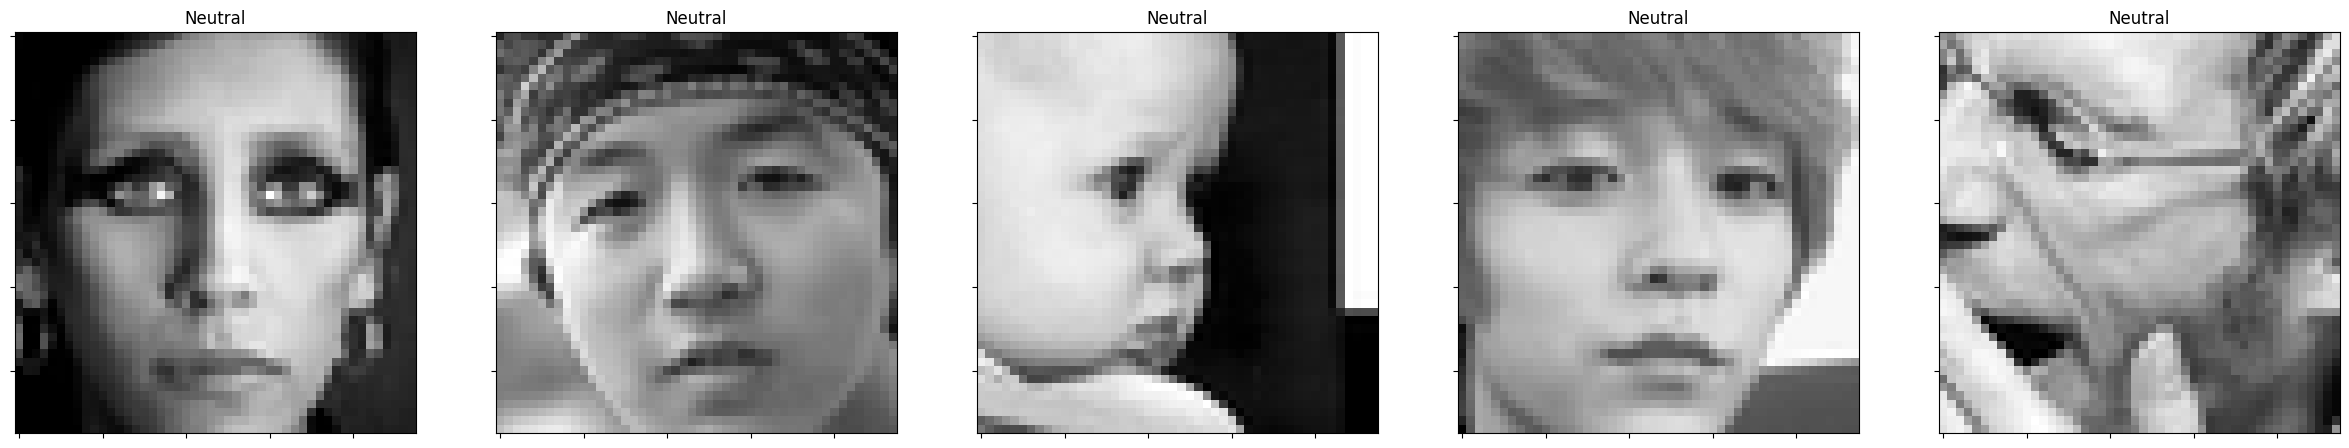

In [19]:
plot_examples(label=6)

In [20]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

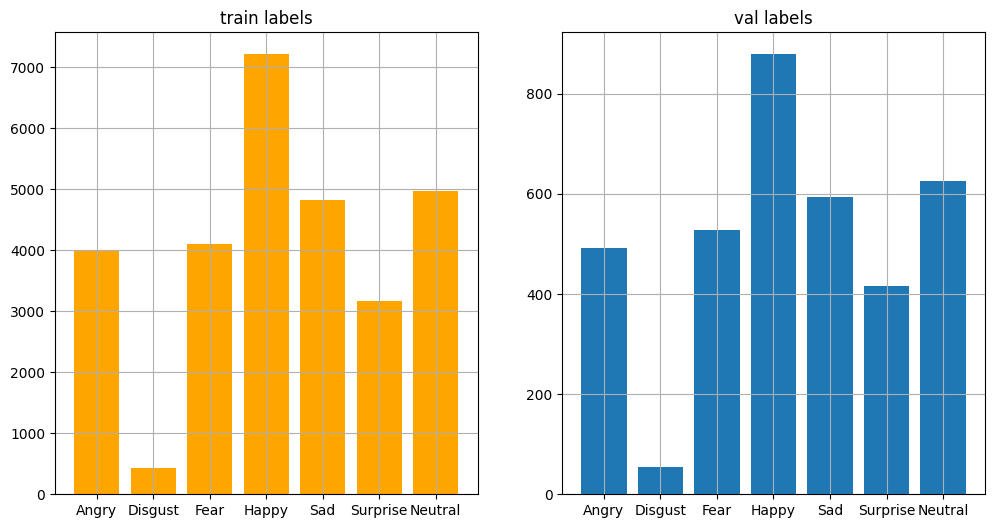

In [21]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [22]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight



{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [23]:
#Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    filepath="best_model.h5",
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

model_checkpoint = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto') 
callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoint
]

In [24]:
#General shape parameters
IMG_SIZE = 48
NUM_CLASSES = 7
BATCH_SIZE = 64

In [25]:
#A plotting function to visualize training progress
def render_history(history, suf=''):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.95,
                        top=0.9,
                        wspace=0.4)
    
    ax1.set_title("Losses")
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('value of the loss function')
    ax1.legend()

    ax2.set_title("Accuracies")
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('value of accuracy')
    ax2.legend()
    
    plt.show()
    suf = '' if suf == '' else '_'+suf
    fig.savefig('loss_and_acc'+suf +'.png')

In [26]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model

#By specifying the include_top=False argument, we load a network that 
#doesn't include the  classification layers at the top, which is ideal for feature extraction.
base_net = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     include_top=False,
                     weights='imagenet')

#plot_model(base_net, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet_full.png')

In [27]:
base_model = Model(inputs = base_net.input,outputs = base_net.get_layer('conv_pw_12_relu').output, name = 'mobilenet_trunc')

In [28]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import Input, Model

global_average_layer = GlobalAvgPool2D()
prediction_layer = Dense(NUM_CLASSES, activation="softmax", name="pred")
inputs_raw = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs_raw, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = Model(inputs=inputs_raw, outputs= outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenet_trunc (Functiona  (None, 1, 1, 1024)        2162880   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 pred (Dense)                (None, 7)                 7175      
                                                                 
Total params: 2170055 (8.28 MB)
Trainable params: 2152263 (8.21 MB)
Non-trainable params: 17792 (69.50 KB)
_________________________________________________________________


In [29]:
for layer in base_model.layers[:]:
    layer.trainable = False

optims = {
    'adam': optimizers.Adam(0.01),
    'nadam': optimizers.Nadam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
}

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims['adam'],
        metrics=['accuracy']
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenet_trunc (Functiona  (None, 1, 1, 1024)        2162880   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 pred (Dense)                (None, 7)                 7175      
                                                                 
Total params: 2170055 (8.28 MB)
Trainable params: 7175 (28.03 KB)
Non-trainable params: 2162880 (8.25 MB)
_________________________________________________________________


In [30]:
initial_epochs = 5
history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                 train_labels, 
                                                 batch_size=BATCH_SIZE),
                              validation_data=(val_images_rgb, 
                                               val_labels),
                              class_weight = class_weight,
                            #   steps_per_epoch=len(train_images) / BATCH_SIZE,
                              #initial_epoch = history.epoch[-1],
                              #epochs = total_epochs,
                              epochs = initial_epochs,
                              callbacks=callbacks)

Epoch 1/5


C:\Users\thien\AppData\Local\Temp\ipykernel_26816\1222884034.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb,


449/449 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.3453
Epoch 1: val_accuracy improved from -inf to 0.39705, saving model to best_model.h5
449/449 [==============================] - 30s 63ms/step - loss: 0.3068 - accuracy: 0.3453 - val_loss: 1.8198 - val_accuracy: 0.3970 - lr: 0.0100
Epoch 2/5


c:\Users\thien\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/449 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.3604
Epoch 2: val_accuracy did not improve from 0.39705
449/449 [==============================] - 27s 61ms/step - loss: 0.3005 - accuracy: 0.3605 - val_loss: 1.9100 - val_accuracy: 0.3831 - lr: 0.0100
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.3706
Epoch 3: val_accuracy did not improve from 0.39705
449/449 [==============================] - 28s 61ms/step - loss: 0.2910 - accuracy: 0.3706 - val_loss: 2.0283 - val_accuracy: 0.3424 - lr: 0.0100
Epoch 4/5
449/449 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.3668
Epoch 4: val_accuracy did not improve from 0.39705
449/449 [==============================] - 27s 61ms/step - loss: 0.3005 - accuracy: 0.3668 - val_loss: 2.1005 - val_accuracy: 0.3689 - lr: 0.0100
Epoch 5/5
449/449 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.3663
Epoch 5: ReduceLROnPlateau reducing lea

In [31]:
iterative_finetuning = True 

In [32]:
if iterative_finetuning:
    ftsuf = 'ft_2'
else:
    ftsuf = 'ft_atonce'


In [33]:
if iterative_finetuning:
    print("Number of layers in the base model: ", len(base_model.layers))
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-37:]: #blocks 7-12
      layer.trainable = True
    optims = {'adam': optimizers.Adam(0.001)}

    model.compile(
            loss='categorical_crossentropy',
            optimizer=optims['adam'],
            metrics=['accuracy']
    )

    model.summary()

Number of layers in the base model:  80
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenet_trunc (Functiona  (None, 1, 1, 1024)        2162880   
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 pred (Dense)                (None, 7)                 7175      
                                                                 
Total params: 2170055 (8.28 MB)
Trainable params: 1883143 (7.18 MB)
Non-trainable params: 286912 (1.09 MB)
______________________________________________

In [34]:
if iterative_finetuning:
    fine_tune_epochs = 100
    total_epochs =  history.epoch[-1] + fine_tune_epochs

    history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb, 
                                                    train_labels, 
                                                    batch_size=BATCH_SIZE),
                                validation_data=(val_images_rgb, 
                                                val_labels),
                                class_weight = class_weight,
                                # steps_per_epoch=len(train_images) / BATCH_SIZE,
                                initial_epoch = history.epoch[-1],
                                epochs = total_epochs,
                                callbacks=callbacks)

Epoch 5/104


C:\Users\thien\AppData\Local\Temp\ipykernel_26816\1861482887.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_rgb_datagen.flow(train_images_rgb,


449/449 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.2311
Epoch 5: val_accuracy did not improve from 0.39705
449/449 [==============================] - 46s 96ms/step - loss: 0.3375 - accuracy: 0.2311 - val_loss: 1.8086 - val_accuracy: 0.2767 - lr: 0.0010
Epoch 6/104
449/449 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.3044
Epoch 6: val_accuracy did not improve from 0.39705
449/449 [==============================] - 43s 96ms/step - loss: 0.2745 - accuracy: 0.3044 - val_loss: 1.7379 - val_accuracy: 0.3589 - lr: 0.0010
Epoch 7/104
449/449 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.3727
Epoch 7: val_accuracy improved from 0.39705 to 0.41376, saving model to best_model.h5
449/449 [==============================] - 45s 100ms/step - loss: 0.2486 - accuracy: 0.3727 - val_loss: 1.5820 - val_accuracy: 0.4138 - lr: 0.0010
Epoch 8/104
449/449 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.39

In [35]:
test_loss, test_acc = model.evaluate(test_images_rgb, test_labels) #, test_labels
print('test caccuracy:', test_acc)


113/113 [==============================] - 3s 26ms/step - loss: 1.2350 - accuracy: 0.5500
test caccuracy: 0.5500139594078064


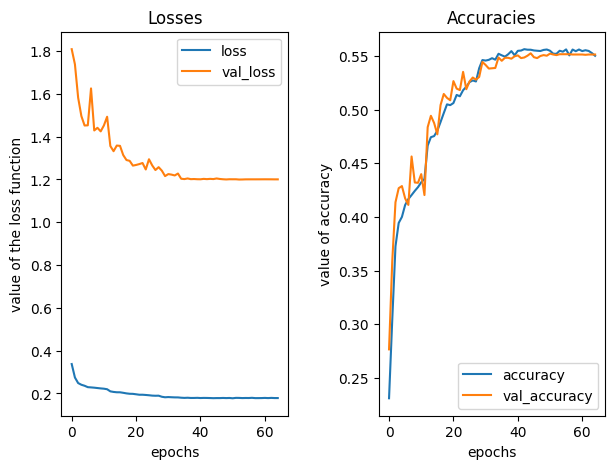

In [36]:
render_history(history, 'mobilenet12blocks_wdgenaug_'+ftsuf)

In [41]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

In [44]:
import random
import ipywidgets as widgets

@widgets.interact
def f(x=random.sample(range(len(test_images)), 25)):
    for i in x:
        plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, i)


In [40]:
import random

# Select 25 random test data points
test_indices = random.sample(range(len(test_images_rgb)), 25)

# Make predictions for the selected test data points
predictions = model.predict(test_images_rgb[test_indices])

# Print the data, true label, and predicted label for each selected test data point
for i in range(25):
    print("Data:", test_images_rgb[test_indices[i]])
    print("True Label:", emotions[test_labels[test_indices[i]].argmax()])
    print("Predicted Label:", emotions[predictions[i].argmax()])
    print()


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 4; input has only 4 dims [Op:StridedSlice] name: strided_slice/